In [131]:
import pandas as pd
from numpy import sqrt,mean,log,diff
import quandl
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader.data import Options
import pandas_datareader.data as web
import datetime
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
quandl.ApiConfig.api_key = 'NxTUTAQswbKs5ybBbwfK'

In [3]:
data = quandl.get('WIKI/GOOG')

In [4]:
# use the daily data of Google(NASDAQ: GOOG) from 01/2016 to 08/2016 
close = data['2016-01':'2016-08']['Adj. Close']
r = diff(log(close))
r_mean = mean(r)
diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
std = sqrt(sum(diff_square)*(1.0/(len(r)-1)))
vol = std*sqrt(252)
vol

0.21326449960467742

In [132]:
def bsm_price(option_type, sigma, s, k, r, T, q):  
    # calculate the bsm price of European call and put option
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r - q)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q)*T) *  stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') %option_type

In [146]:
def implied_vol(option_type, option_price, s, k, r, T, q):
    # apply bisection method to get the implied volatility by solving the BSM function
    precision = 0.00001
    upper_vol = 500.0
    max_vol = 500.0
    min_vol = 0.000
    lower_vol = 0.000
    iteration = 0    

    while 1:
        iteration +=1 
        mid_vol = (upper_vol + lower_vol)/2.0
        price = bsm_price(option_type, mid_vol, s, k, r, T, q)
        if option_type == 'c':

            lower_price = bsm_price(option_type, lower_vol, s, k, r, T, q)
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol 
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break
            if mid_vol > max_vol - 5 : 
                mid_vol = 0
                break
#             print("mid_vol=%f" %mid_vol)
#             print("upper_price=%f" %lower_price)

        elif option_type == 'p':
            upper_price = bsm_price(option_type, upper_vol, s, k, r, T, q)

            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol 
            else:
                lower_vol = mid_vol
            
#             print("mid_vol=%f" %mid_vol)
#             print("upper_price=%f" %upper_price)            
            if abs(price - option_price) < precision: break 
            if iteration > 100: break
                
    return mid_vol 

In [197]:
# download option data for all expiry months from Yahoo Finance 
# provide a formatted DataFrame with a hierarchical index
opt = Options('spy', 'yahoo')

In [198]:
opt.expiry_dates

[datetime.date(2017, 8, 11),
 datetime.date(2017, 8, 16),
 datetime.date(2017, 8, 18),
 datetime.date(2017, 8, 23),
 datetime.date(2017, 8, 25),
 datetime.date(2017, 8, 30),
 datetime.date(2017, 9, 1),
 datetime.date(2017, 9, 6),
 datetime.date(2017, 9, 8),
 datetime.date(2017, 9, 13),
 datetime.date(2017, 9, 15),
 datetime.date(2017, 9, 22),
 datetime.date(2017, 9, 29),
 datetime.date(2017, 10, 20),
 datetime.date(2017, 11, 17),
 datetime.date(2017, 12, 15),
 datetime.date(2017, 12, 29),
 datetime.date(2018, 1, 19),
 datetime.date(2018, 3, 16),
 datetime.date(2018, 3, 29),
 datetime.date(2018, 6, 15),
 datetime.date(2018, 6, 29),
 datetime.date(2018, 7, 20),
 datetime.date(2018, 9, 21),
 datetime.date(2018, 12, 21),
 datetime.date(2019, 1, 18),
 datetime.date(2019, 3, 15),
 datetime.date(2019, 6, 21),
 datetime.date(2019, 12, 20),
 datetime.date(2020, 7, 17)]

In [254]:
# choose contracts with specified expiry date
expiry_index = 16
expiry = opt.expiry_dates[expiry_index]
data_call = opt.get_call_data(expiry=expiry)

In [255]:
len(data_call) # number of contracts with specified expiry date

85

In [256]:
r = 0.01 # risk free rate
s = data_call['Underlying_Price'] # undelying price
expiry = data_call.index.get_level_values('Expiry')[0] # get the expiry 
current_date = datetime.datetime.now() # get the current date
time_to_expire = float((expiry - current_date).days)/365 # compute time to expiration
premium = (data_call['Ask'] + data_call['Bid'])/2 # option premium
k_call = data_call.index.get_level_values('Strike') # get the strike price
d = 0.01 # continuous devidend yield

In [257]:
IV_call = []
for i in range(len(data_call)):  
    IV_call.append(implied_vol('c', premium.values[i], s.values[i], k_call[i], r, time_to_expire, d))

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


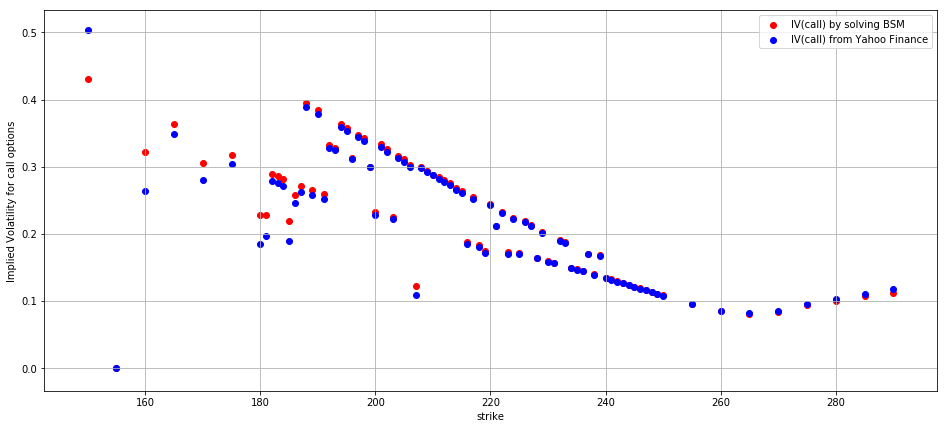

In [258]:
# compare the implied volatility calculated by BSM and given by Yahoo Finance
plt.figure(figsize=(16, 7))
a = plt.scatter(k_call,IV_call, c='r', label="IV by solving BSM")
b = plt.scatter(k_call,data_call['IV'],c = 'b', label="IV from Yahoo Finance")
plt.grid()
plt.xlabel('strike')
plt.ylabel('Implied Volatility for call options')
plt.legend((a,b), ("IV(call) by solving BSM", "IV(call) from Yahoo Finance"))

In [259]:
# choose contracts with specified expiry date
expiry = opt.expiry_dates[expiry_index]
data_put = opt.get_put_data(expiry=expiry)
r = 0.013 # risk free rate
s = data_put['Underlying_Price'] # undelying price
expiry = data_put.index.get_level_values('Expiry')[0] # get the expiry 
current_date = datetime.datetime.now() # get the current date
time_to_expire = float((expiry - current_date).days)/365 # compute time to expiration
premium = (data_put['Ask'] + data_put['Bid'])/2 # option premium
k_put = data_put.index.get_level_values('Strike') # get the strike price
d = 0.01 # continuous devidend yield

In [260]:
len(data_put) # number of contracts with specified expiry date

85

In [261]:
IV_put = []
for i in range(len(data_put)):  
    IV_put.append(implied_vol('p', premium.values[i], s.values[i], k_put[i], r, time_to_expire, d))

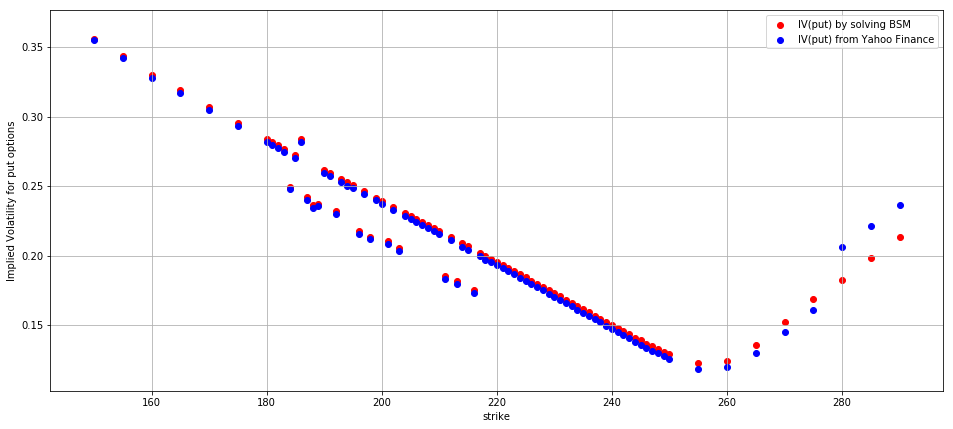

In [262]:
plt.figure(figsize=(16, 7))
c = plt.scatter(k_put,IV_put, c='r', label="IV by solving BSM")
d = plt.scatter(k_put,data_put['IV'],c = 'b', label="IV from Yahoo Finance")
plt.grid()
plt.xlabel('strike')
plt.ylabel('Implied Volatility for put options')
plt.legend((c,d), ("IV(put) by solving BSM", "IV(put) from Yahoo Finance"))

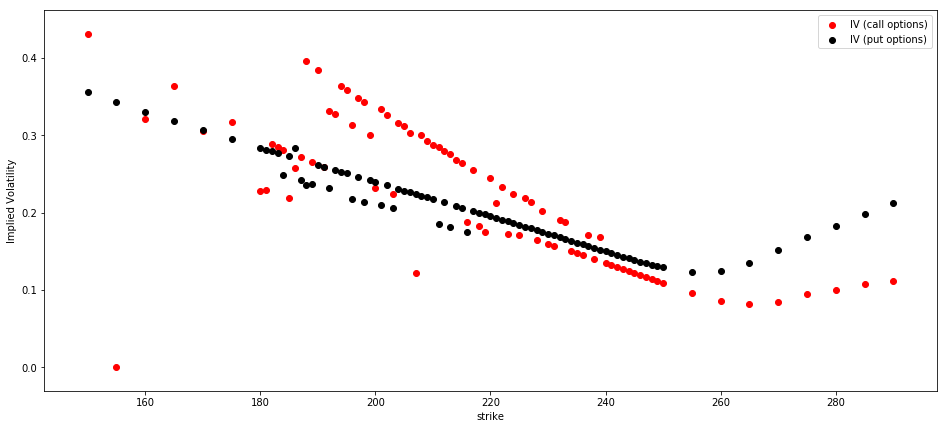

In [263]:
plt.figure(figsize=(16, 7))
e = plt.scatter(k_call,IV_call, c ='red', label="IV(call options)")
f = plt.scatter(k_put,IV_put, c = 'black', label="IV(put options)")
plt.xlabel('strike')
plt.ylabel('Implied Volatility')
plt.legend((e,f), ("IV (call options)", "IV (put options)"))